# Learning to trace geometrical paths for faster Ray Tracing

TODO

In [1]:
from collections.abc import Iterator
from typing import Any, Optional

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from beartype import beartype as typechecker
from jaxtyping import Array, Bool, Float, Int, PRNGKeyArray, Shaped, jaxtyped
from tqdm.notebook import trange

from differt2d.logic import is_true
from differt2d.geometry import ImagePath, Point, Wall
from differt2d.scene import Scene

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Motivation

When performing 

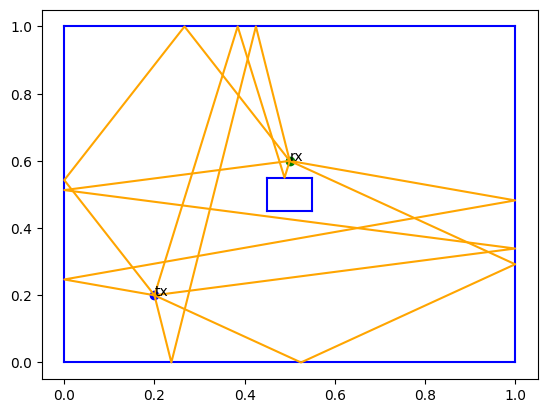

In [2]:
ax = plt.gca()
scene = Scene.square_scene_with_obstacle()
scene.plot(ax)

order = 2

for _, _, path, _ in scene.all_valid_paths(
    order=order
):
    path.plot(ax)

xlim = plt.xlim()
ylim = plt.ylim()

plt.show()

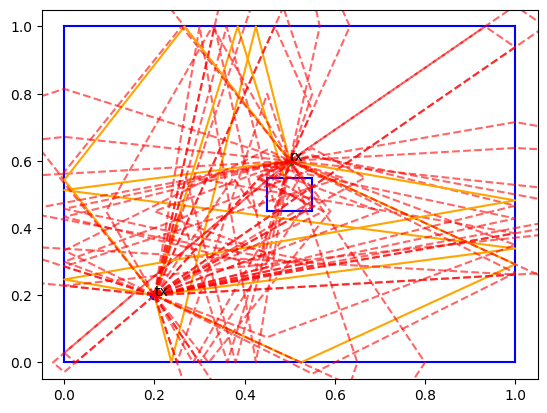

In [3]:
ax = plt.gca()
scene.plot(ax)

for _, _, valid, path, path_candidate in scene.all_paths(
    min_order=order, max_order=order
):
    if is_true(valid):
        path.plot(ax)
    else:
        path.plot(ax, linestyle="--", color="red", alpha=0.6)

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.show()

## Training data generation

In [4]:
key = jax.random.PRNGKey(12345)
key, key_example_scene = jax.random.split(key, 2)


def random_scenes(
    min_ratio: float = 0.24,
    max_ratio: float = 0.26,
    min_num_walls: int = 4,
    min_angle: float = -0.0 * jnp.pi,
    max_angle: float = +0.0 * jnp.pi,
    *,
    key: PRNGKeyArray,
) -> Iterator[tuple[Scene, Float[Array, "2+num_walls*2 2"]]]:
    """
    Returns a generator of random variant of :func:`Scene.square_scene_with_obstacle`.

    :param key: TODO.
    """
    while True:
        key, key_ratio, key_tx_rx, key_num_walls, key_walls, key_angles = (
            jax.random.split(key, 6)
        )
        # A random scaling is applied to the inner square
        ratio = jax.random.uniform(key_ratio, minval=min_ratio, maxval=max_ratio)
        # TX and RX are randomly sampled
        points = jax.random.uniform(key_tx_rx, (2, 2))
        tx = Point(xy=points[0, :])
        rx = Point(xy=points[1, :])
        scene = Scene.square_scene_with_obstacle(ratio=ratio)
        center = scene.center()
        indices = jnp.arange(len(scene.objects), dtype=jnp.int32)
        # The number of walls is random
        num_walls = jax.random.randint(
            key_num_walls, (), minval=min_num_walls, maxval=len(scene.objects) + 1
        )
        # Walls are shuffled (to make sure deepset models is permutation invariant, but should not be needed)
        wall_indices = jax.random.choice(
            key_walls, indices, shape=(num_walls,), replace=False
        )
        # Each wall receives a random permutation around the center of the scene
        angles = jax.random.uniform(
            key_angles, shape=(num_walls,), minval=min_angle, maxval=max_angle
        )
        objects = [
            scene.objects[wall_index].rotate(angle=angle, around=center)
            for wall_index, angle in zip(wall_indices, angles)
        ]

        points = jnp.vstack([points, *[obj.xys for obj in objects]])

        yield (
            scene.with_transmitters(tx=tx).with_receivers(rx=rx).with_objects(*objects),
            points,
        )


def samples(
    order: int, **kwargs: Any
) -> Iterator[tuple[Float[Array, "2+num_walls*2 2"], Int[Array, "num_paths {order}"]]]:
    """
    Returns a generator of random (train or test) samples for the model.

    :param order: The order of the paths to generate.
    :param kwargs: Keyword arguments passed to :func:`random_scenes`.
    :return: A generator of (scene coordinates, path_candidates).
    """
    for scene, points in random_scenes(**kwargs):
        path_candidates = [
            path_candidate
            for _, _, _, path_candidate in scene.all_valid_paths(
                min_order=order, max_order=order, approx=False
            )
        ]

        # Handle edge case with no path
        if len(path_candidates) > 0:
            path_candidates = jnp.stack(path_candidates, dtype=jnp.int32)
        else:
            path_candidates = jnp.zeros((0, order), dtype=jnp.int32)

        yield points, path_candidates


scenes = random_scenes(key=key_example_scene)

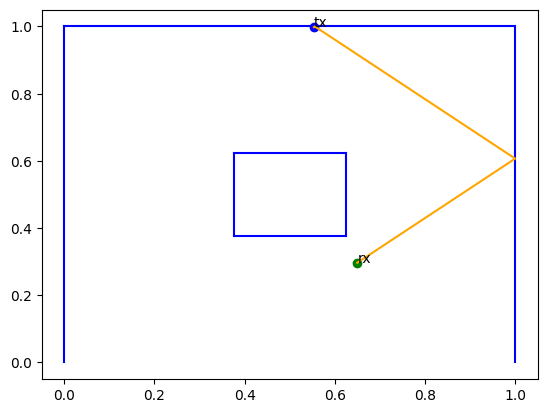

In [5]:
ax = plt.gca()
scene, _ = next(scenes)
scene.plot(ax)

for _, _, path, _ in scene.all_valid_paths(
    order=order
):
    path.plot(ax)

plt.show()

In [6]:
key, key_model, key_train, key_samples = jax.random.split(key, 4)
key_train_samples, key_test_samples = jax.random.split(key_samples, 2)

# Let's filter out the cases with not valid paths, because they are not intersting to learn from.

train_samples = filter(lambda args: args[0].shape[0] > 0, samples(order=order, key=key_train_samples))
test_samples = filter(lambda args: args[0].shape[0] > 0, samples(order=order, key=key_test_samples))

In [7]:
@jax.jit
@jaxtyped(typechecker=typechecker)
def row_in_matrix(
    row: Shaped[Array, " num_cols"], matrix: Shaped[Array, "num_rows num_cols"]
) -> Bool[Array, " "]:
    bool_ = jax.vmap(jnp.equal, in_axes=(None, 0))(row, matrix)
    return jnp.any(jnp.all(bool_, axis=1), axis=0)

@jax.jit
@jaxtyped(typechecker=typechecker)
def reward(
    pred_path_candidate: Int[Array, "order"],
    true_path_candidates: Int[Array, "num_paths order"],
) -> Float[Array, " "]:
    pred_in_true = row_in_matrix(pred_path_candidate, true_path_candidates)

    return jnp.sum(pred_in_true.astype(float))

# Model definition

In [8]:
class FlowModel(eqx.Module):
    order: int = eqx.field(static=True)
    # Layers
    scene_2_embeddings: eqx.nn.MLP
    """MLP that is applied to each object in parallel and returns embeddings."""
    state_and_embeddings_2_flow: eqx.nn.MLP
    """MLP that maps each possible choice to some positive flow."""

    def __init__(
        self,
        # Hyperparameters
        order: int,
        num_embeddings: int = 100,
        *,
        key: PRNGKeyArray,
    ):

        key1, key2 = jax.random.split(key, 2)

        if order < 0:
            raise ValueError(f"Order must be greater or equal to 0, got {order}.")

        self.order = order
        # Layers
        self.scene_2_embeddings = eqx.nn.MLP(
            in_size=2,
            out_size=num_embeddings,
            width_size=500,
            depth=3,
            key=key1,
        )
        self.state_and_embeddings_2_flow = eqx.nn.MLP(
            in_size=order + num_embeddings,
            out_size="scalar",
            width_size=500,
            depth=3,
            final_activation=jnp.exp,
            key=key2,
        )
        
    @eqx.filter_jit
    @jaxtyped(typechecker=typechecker)
    def __call__(
        self,
        state: Float[Array, "num_walls order"],
        index: Int[Array, " "],
        xys: Float[Array, "2+num_walls*2 2"],
        *,
        key: PRNGKeyArray,
    ) -> tuple[Float[Array, "num_walls"], Int[Array, " "]]:
        assert xys.shape[0] >= 4, "Scene must at least have two points, tx and rx, and one wall!"

        # Data normalization
        eps = 1e-5
        mean = jnp.mean(xys, axis=0, keepdims=True)
        std = jnp.std(xys, axis=0, keepdims=True)

        xys = (xys - mean) / (std + eps)

        # [num_embeddings]
        embeddings = jnp.sum(jax.vmap(self.scene_2_embeddings)(xys), axis=0)

        # [num_walls num_embeddings]
        embeddings = jnp.tile(embeddings, (state.shape[0], 1))

        flow = jax.vmap(self.state_and_embeddings_2_flow)(jnp.hstack((state, embeddings)))

        flow = jnp.where(index >= 0, flow.at[index].set(0.0), flow)

        p = flow / jnp.sum(flow)

        index = jax.random.categorical(key=key, logits=jnp.log(p))  # Action to take

        return flow, index

## Loss function definition

In [20]:
@jaxtyped(typechecker=None)
def loss(
    model: FlowModel,
    xys: Float[Array, "2+num_walls*2 2"],
    true_path_candidates: Int[Array, "num_paths order"],
    batch_size: int = 10,
    plot: bool = False,
    *,
    key: PRNGKeyArray,
) -> Float[Array, " "]:
    """
    Compute the loss of the model on a specific input scene.

    The loss is accumulated over the generation of 'batch_size' path candidates.
    """
    num_walls = (xys.shape[0] - 2) // 2
    order = true_path_candidates.shape[1]

    ScanR = Int[Array, " "]
    ScanC = tuple[Float[Array, " "], Float[Array, " num_walls"], ScanR, Float[Array, "num_walls order"]]
    
    @jaxtyped(typechecker=typechecker)
    def scan_fn(carry: ScanC, key_and_current_order: tuple[PRNGKeyArray, Int[Array, " "]]) -> tuple[ScanC, ScanR]:
        # We carry, for the currently generated path candidates:
        # - the flow mismatch (parent edges flow - current flow)
        # - the parent edge flow (only one parent leads to the current choice)
        # - the parent index
        # - the state (path candidate using one-hot encoding)
        flow_mismatch, parent_edge_flow_prediction, index, state = carry
        key, current_order = key_and_current_order

        edge_flow_prediction, index = model(state, index, xys, key=key)

        flow_mismatch += (parent_edge_flow_prediction[index] - jnp.sum(edge_flow_prediction)) ** 2

        # Indicate we have chosen walls[index] as a candidate at 'current_order'
        state = state.at[index, current_order].set(1.0)

        jax.debug.print("State at {current_order} {index}: {state}", current_order=current_order, index=index, state=state)

        return (flow_mismatch, edge_flow_prediction, index, state), index

    BatchC = Float[Array, " "]
    BatchR = Int[Array, " order"]
            
    @jaxtyped(typechecker=typechecker)
    def batch_fn(batch_loss: BatchC, key: PRNGKeyArray) -> tuple[BatchC, BatchR]:
        key_init, key_scan, key_last_state = jax.random.split(key, 3)
        num_scan = max(order - 1, 0)
        flow_mismatch = jnp.array(0.0)
        index = jnp.array(-1)
        state = jnp.zeros((num_walls, order))
        jax.debug.print("State at 0 {index}: {state}", index=index, state=state)
        parent_edge_flow_prediction, index = model(state, index, xys, key=key_init)
        init = flow_mismatch, parent_edge_flow_prediction, index, state
        (flow_mismatch, edge_flow_prediction, index, state), pred_path_candidate = jax.lax.scan(scan_fn, init, xs=(jax.random.split(key, num_scan), jnp.arange(num_scan)))

        edge_flow_prediction, index = model(state, index, xys, key=key)
        pred_path_candidate = jnp.concatenate((pred_path_candidate, jnp.atleast_1d(index)))
        state = state.at[index, -1].set(1.0)
        jax.debug.print("State at -1 {index}: {state}", index=index, state=state)
        flow_mismatch += (parent_edge_flow_prediction[index] - reward(pred_path_candidate, true_path_candidates)) ** 2

        return batch_loss + flow_mismatch, pred_path_candidate

    batch_loss = jnp.array(0.0)
    batch_loss, pred_path_candidates = jax.lax.scan(batch_fn, batch_loss, xs=jax.random.split(key, batch_size))

    if plot:
        order = true_path_candidates.shape[1]
        tx = Point(xy=xys[0, :])
        rx = Point(xy=xys[1, :])
        walls = xys[2:].reshape(-1, 2, 2)
        scene = Scene(
            transmitters={"tx": tx},
            receivers={"rx": rx},
            objects=[Wall(xys=wall) for wall in walls],
        )
        ax = plt.gca()
        scene.plot(ax)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        for _, _, path, _ in scene.all_valid_paths(
            order=order
        ):
            path.plot(ax, color="orange")

        for pred_path_candidate in jnp.unique(pred_path_candidates, axis=0):
            objects = [scene.objects[i] for i in pred_path_candidate]
            ImagePath.from_tx_objects_rx(tx, objects, rx).plot(
                ax, linestyle="--", alpha=0.5, color="red"
            )

    return batch_loss

In [21]:
training_model = FlowModel(order=order, key=key_model)
optim = optax.adam(learning_rate=3e-4)

State at 0 -1: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at 0 2: [[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at -1 4: [[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]]
State at 0 -1: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at 0 1: [[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at -1 5: [[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]]
State at 0 -1: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at 0 1: [[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at -1 3: [[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]]
State at 0 -1: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at 0 1: [[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at -1 5: [[0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]]
State at 0 -1: [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at 0 2: [[0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
State at -1 3: [[0. 0.]
 

Array(178.74922, dtype=float32)

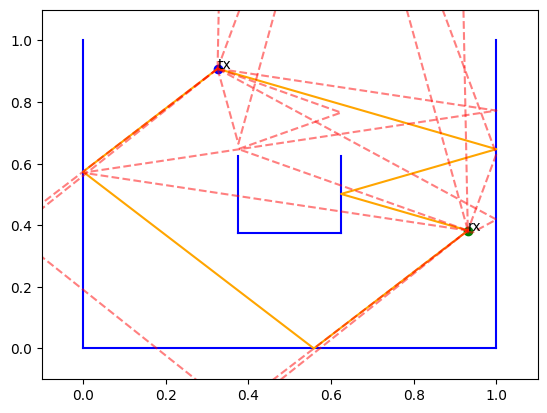

In [22]:
key, key_loss_untrained = jax.random.split(key, 2)
loss(training_model, *next(train_samples), plot=True, key=key_loss_untrained)  # Untrained model

In [12]:
def train(
    model: FlowModel,
    train_samples: Iterator,
    optim: optax.GradientTransformation,
    steps: int = 2_000,
    print_every: int = 100,
    *,
    key: PRNGKeyArray,
) -> tuple[FlowModel, Float[Array, "{steps}"]]:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model: FlowModel,
        opt_state: optax.OptState,
        xys: Float[Array, "2+num_walls*2 2"],
        true_path_candidates: Float[Array, "num_paths order"],
        *,
        key: PRNGKeyArray,
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(
            model, xys, true_path_candidates, key=key
        )
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    losses = []

    with trange(steps, desc="", unit=" steps", leave=True) as bar:
        for step, (x_train, y_train) in zip(bar, train_samples):
            key, key_step = jax.random.split(key, 2)

            model, opt_state, train_loss = make_step(
                model, opt_state, x_train, y_train, key=key_step
            )
            losses.append(train_loss)
            if (step % print_every) == 0 or (step == steps - 1):
                bar.set_description(
                    f"train_loss = {float(train_loss):.1f}"
                )

    return model, jnp.array(losses)

  0%|          | 0/2000 [00:00<?, ? steps/s]

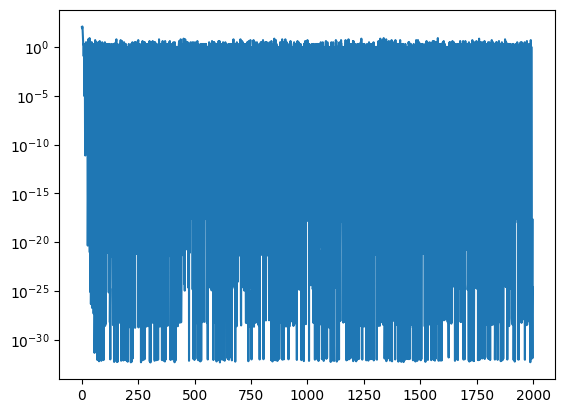

In [14]:
training_model, losses = train(
    training_model, train_samples, optim, key=key_train
)
inference_model = eqx.nn.inference_mode(training_model)

plt.semilogy(losses)

Array(1., dtype=float32)

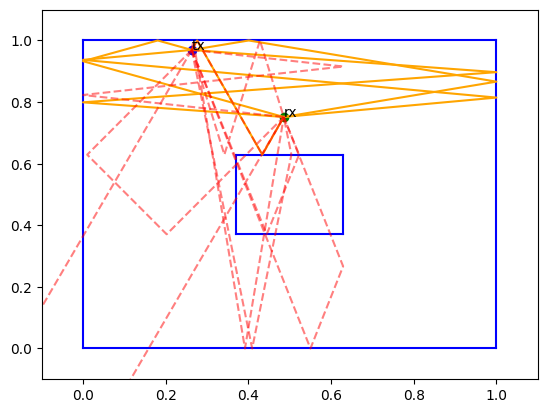

In [19]:
key, key_loss_trained = jax.random.split(key, 2)

loss(inference_model, *next(test_samples), plot=True, key=key_loss_trained)

In [ ]:
state = jnp.zeros((10, 5))

In [ ]:
state.at[1, 2].set(9.0)